In [2]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.metrics import mean_absolute_error, r2_score

In [3]:
# Cargar datos
path_datos = os.path.join('..','..','Datos','Limpios')
df2 = pd.read_csv(os.path.join(path_datos,'datos2_limpios.csv'), index_col=0)

df2_limpio = df2.drop(['Porcentaje Ahorro (%)', 'Ahorro Actual (€)', 'Gasto Mensual (€)',
                        'Vida Esperada (años)', 'Edad de Jubilación'], axis=1)

In [4]:
# Definir variables de entrada y salida
X = df2_limpio.drop(columns=['Años Hasta Jubilación'])
y = df2_limpio['Años Hasta Jubilación']

In [5]:
# Dividir en train y test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Modelos: RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor y DecisionTreeRegressor

In [6]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
# Modelos iniciales
base_models = {
    'random_forest': RandomForestRegressor(random_state=42),
    'extra_trees': ExtraTreesRegressor(random_state=42),
    'bagging': BaggingRegressor(estimator=DecisionTreeRegressor(), random_state=42),
    'decision_tree': DecisionTreeRegressor(random_state=42)
}

In [7]:
# Hiperparámetros a optimizar
model_hyperparameters = {
    'random_forest': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'extra_trees': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'bagging': {
        'n_estimators': [50, 100, 200],
        'max_samples': [0.5, 0.75, 1.0]
    },
    'decision_tree': {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10]
    }
}

In [8]:
best_models = {}
results = []

# 1️ Optimizar hiperparámetros para cada modelo
for name, model in base_models.items():
    print(f"Optimizing {name}...")
    grid = GridSearchCV(model, model_hyperparameters[name], cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
    grid.fit(X_train, y_train)
    
    best_models[name] = grid.best_estimator_  # Guardamos el mejor modelo
    results.append({
        'model': name,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    })


Optimizing random_forest...
Optimizing extra_trees...
Optimizing bagging...
Optimizing decision_tree...


In [9]:
pd.DataFrame(results)

,model,best_score,best_params
0,random_forest,-1.485511,"{'max_depth': 10, 'min_samples_split': 10, 'n_..."
1,extra_trees,-1.447522,"{'max_depth': 10, 'min_samples_split': 10, 'n_..."
2,bagging,-1.516645,"{'max_samples': 0.5, 'n_estimators': 100}"
3,decision_tree,-1.611278,"{'max_depth': 10, 'min_samples_split': 10}"


In [10]:
# 2️ Comparar modelos ya optimizados
final_results = []
for name, model in best_models.items():
    cv_score = cross_validate(model, X_train, y_train, scoring=['neg_mean_absolute_error', 'r2'], cv=5)
    
    mean_mae = np.mean(cv_score['test_neg_mean_absolute_error'])
    mean_r2 = np.mean(cv_score['test_r2'])
    
    final_results.append({
        'model': name,
        'MAE': mean_mae,
        'R2': mean_r2,
        'best_hyperparameters': grid.best_params_
    })


In [11]:
# 3️ Elegir el mejor modelo basado en MAE y R²
best_model = sorted(final_results, key=lambda x: x['MAE'], reverse=True)  # Ordenar por menor MAE
pd.DataFrame(best_model)


,model,MAE,R2,best_hyperparameters
0,extra_trees,-1.447522,0.981311,"{'max_depth': 10, 'min_samples_split': 10}"
1,random_forest,-1.485511,0.979997,"{'max_depth': 10, 'min_samples_split': 10}"
2,bagging,-1.516645,0.979125,"{'max_depth': 10, 'min_samples_split': 10}"
3,decision_tree,-1.611278,0.976302,"{'max_depth': 10, 'min_samples_split': 10}"


Se puede hacer la prueba con varios y ver que resultados dan.

### Usar el modelo en dataset2

In [12]:
# Cargar nuevo dataset
df = pd.read_csv(os.path.join(path_datos, 'datos1_limpios.csv'), index_col=0)

In [13]:
X_2 = df.drop(['ID', 'FECHA NAC', 'SEXO', 'FECHA ENTRADA', 'PARA CONTAR MESES'], axis=1)
X_2.columns = ['Ingreso Anual (€)','Edad']
X_2 = X_2[['Edad','Ingreso Anual (€)']] 
X_2.head()

,Edad,Ingreso Anual (€)
0,51,15319.07
1,30,19168.80
2,52,18719.86
3,50,12942.60
4,49,20158.08


### Prueba con RandomForestClassifier:

In [14]:
rf=  RandomForestRegressor(max_depth=10, min_samples_split=10, n_estimators=100, random_state=42)
rf.fit(X_train, y_train) 

RandomForestRegressor(max_depth=10, min_samples_split=10, random_state=42)

In [15]:
# Predecir
predicciones = rf.predict(X_2)
df['AÑOS HASTA JUBILACION'] = predicciones
df['EDAD DE JUBILACION'] = df['EDAD'] + df['AÑOS HASTA JUBILACION']

<Axes: >

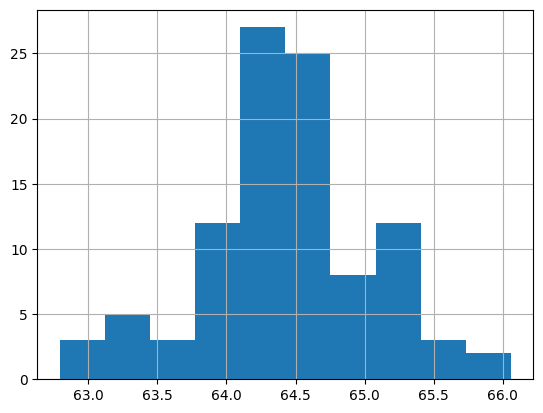

In [16]:
df['EDAD DE JUBILACION'].hist()

In [17]:
df['EDAD DE JUBILACION'].max()

np.float64(66.05693324963002)

In [18]:
df['EDAD DE JUBILACION'].min()

np.float64(62.79520098719412)

In [19]:
import pickle

In [20]:
with open('modelo.pkl', 'wb') as handle:
    pickle.dump(rf, handle)

### Prueba con ExtraTreeRegressor:

In [85]:
et=  ExtraTreesRegressor(max_depth=10, min_samples_split=10, n_estimators=200, random_state=42)
et.fit(X_train, y_train) 

ExtraTreesRegressor(max_depth=10, min_samples_split=10, n_estimators=200,
                    random_state=42)

In [86]:
# Predecir
predicciones = et.predict(X_2)
df['AÑOS HASTA JUBILACION'] = predicciones
df['EDAD DE JUBILACION'] = df['EDAD'] + df['AÑOS HASTA JUBILACION']

<Axes: >

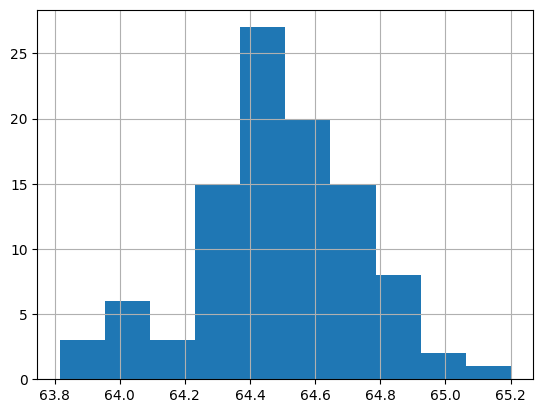

In [87]:
df['EDAD DE JUBILACION'].hist()

In [88]:
df['EDAD DE JUBILACION'].max()

np.float64(65.20087436233537)

In [89]:
df['EDAD DE JUBILACION'].min()

np.float64(63.8162963831031)

### Conclusiones

El modelo con mejores resutados,ExtraTreeRegressor, predice valores parecidos a la media (entre 63.8 y 65.2). Por otro lado RandomForestClassifier, aunque no tenga resultados tan buenos como ExtraTreeRegressor, da valores mas variados (entre 62.7 y 66), por eso puede ser mejor opción ya que se asemeja más a la realidad.